# Importing libraries

In [85]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.pipeline import make_pipeline
import shap
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder

# Importing data

The previously exported cleaned dataset will be imported.

In [86]:
df = pd.read_csv(r"C:\Users\bakerai\Documents\BPP\professional prac\Assignment\Public\SteamDataCleaned.csv")

df['release_date'] = df['release_date'].apply(pd.to_datetime, errors='coerce')

pd.options.display.max_columns = 250
df.head(20)

,Unnamed: 0,appid,name,release_date,required_age,price,dlc_count,detailed_description,about_the_game,short_description,header_image,website,support_url,support_email,windows,mac,linux,achievements,screenshots,movies,positive,negative,estimated_owners,average_playtime_forever,average_playtime_2weeks,median_playtime_forever,median_playtime_2weeks,discount,peak_ccu,main_genre,sub_genre1,sub_genre2,main_developer,main_publisher,lang_Afrikaans,lang_Albanian,lang_Amharic,lang_Arabic,lang_Armenian,lang_Assamese,lang_Azerbaijani,lang_Bangla,lang_Basque,lang_Belarusian,lang_Bosnian,lang_Bulgarian,lang_Catalan,lang_Cherokee,lang_Croatian,lang_Czech,lang_Danish,lang_Dari,lang_Dutch,lang_English,lang_Estonian,lang_Filipino,lang_Finnish,lang_French,lang_Galician,lang_Georgian,lang_German,lang_Greek,lang_Gujarati,lang_Hausa,lang_Hebrew,lang_Hindi,lang_Hungarian,"lang_Hungarian,Polish",lang_Icelandic,lang_Igbo,lang_Indonesian,lang_Irish,lang_Italian,lang_Japanese,lang_K'iche',lang_Kannada,lang_Kazakh,lang_Khmer,lang_Kinyarwanda,lang_Konkani,lang_Korean,lang_Kyrgyz,lang_Latvian,lang_Lithuanian,lang_Luxembourgish,lang_Macedonian,lang_Malay,lang_Malayalam,lang_Maltese,lang_Maori,lang_Marathi,lang_Mongolian,lang_Nepali,lang_Norwegian,lang_Odia,lang_Persian,lang_Polish,lang_Portuguese - Brazil,lang_Portuguese - Portugal,lang_Punjabi (Gurmukhi),lang_Punjabi (Shahmukhi),lang_Quechua,lang_Romanian,lang_Russian,lang_Scots,lang_Serbian,lang_Simplified Chinese,lang_Sindhi,lang_Sinhala,lang_Slovak,lang_Slovenian,lang_Sorani,lang_Sotho,lang_Spanish - Latin America,lang_Spanish - Spain,lang_Swahili,lang_Swedish,lang_Tajik,lang_Tamil,lang_Tatar,lang_Telugu,lang_Thai,lang_Tigrinya,lang_Traditional Chinese,lang_Tswana,lang_Turkish,lang_Turkmen,lang_Ukrainian,lang_Urdu,lang_Uyghur,lang_Uzbek,lang_Valencian,lang_Vietnamese,lang_Welsh,lang_Wolof,lang_Xhosa,lang_Yoruba,lang_Zulu,audio_Afrikaans,audio_Albanian,audio_Amharic,audio_Arabic,audio_Armenian,audio_Assamese,audio_Azerbaijani,audio_Bangla,audio_Basque,audio_Belarusian,audio_Bosnian,audio_Bulgarian,audio_Catalan,audio_Cherokee,audio_Croatian,audio_Czech,audio_Danish,audio_Dari,audio_Dutch,audio_English,audio_Estonian,audio_Filipino,audio_Finnish,audio_French,audio_Galician,audio_Georgian,audio_German,audio_Greek,audio_Gujarati,audio_Hausa,audio_Hebrew,audio_Hindi,audio_Hungarian,audio_Icelandic,audio_Igbo,audio_Indonesian,audio_Irish,audio_Italian,audio_Japanese,audio_K'iche',audio_Kannada,audio_Kazakh,audio_Khmer,audio_Kinyarwanda,audio_Konkani,audio_Korean,audio_Kyrgyz,audio_Latvian,audio_Lithuanian,audio_Luxembourgish,audio_Macedonian,audio_Malay,audio_Malayalam,audio_Maltese,audio_Maori,audio_Marathi,audio_Mongolian,audio_Nepali,audio_Norwegian,audio_Odia,audio_Persian,audio_Polish,audio_Portuguese - Brazil,audio_Portuguese - Portugal,audio_Punjabi (Gurmukhi),audio_Punjabi (Shahmukhi),audio_Quechua,audio_Romanian,audio_Russian,audio_Scots,audio_Serbian,audio_Simplified Chinese,audio_Sindhi,audio_Sinhala,audio_Slovak,audio_Slovenian,audio_Sorani,audio_Sotho,audio_Spanish - Latin America,audio_Spanish - Spain,audio_Swahili,audio_Swedish,audio_Tajik,audio_Tamil,audio_Tatar,audio_Telugu,audio_Thai,audio_Tigrinya,audio_Traditional Chinese,audio_Tswana,audio_Turkish,audio_Turkmen,audio_Ukrainian,audio_Urdu,audio_Uyghur,audio_Uzbek,audio_Valencian,audio_Vietnamese,audio_Welsh,audio_Wolof,audio_Xhosa,audio_Yoruba,audio_Zulu
0,8,221680,Rocksmith® 2014 Edition REMASTERED LEARN & PLAY,2024-12-19,0,2.99,1191,Rocksmith 2014 Remastered is back by popular d...,Rocksmith 2014 Remastered is back by popular d...,Play guitar or bass and start your musical jou...,Image Attached,Website Available,Support Available,No Support,1,0,0,47,7,1,20937,2544,1500000,3033.0,28.0,456.0,28.0,70.0,704,Casual,Simulation,NaN,Ubisoft - San Francisco,Ubisoft,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0

In [87]:
# 1) Quick look at each column’s dtype:
print(df.dtypes)


Unnamed: 0               int64
appid                    int64
name                    object
release_date    datetime64[ns]
required_age             int64
                     ...      
audio_Welsh              int64
audio_Wolof              int64
audio_Xhosa              int64
audio_Yoruba             int64
audio_Zulu               int64
Length: 241, dtype: object


# Machine Learning

Using the previously discovered insights from the EDA, a machine learning tool will be created to predict user review scores.

In [88]:
# Helper function - Will be used to mimic Steams review system / binnings.
def steam_category(row):
    pct = row['review_percentage']
    n = row['n_reviews']

    # positive bins
    if pct >= 95:
        if n >= 500: return 'Overwhelmingly Positive'
        elif n >= 50: return 'Very Positive'
        else: return 'Mostly Positive'
    elif pct >= 85:
        if n >= 50: return 'Very Positive'
        else: return 'Mostly Positive'
    elif pct >= 80:
        return 'Mostly Positive'

    # Middle bins
    elif pct >= 70: return 'Mixed'
    elif pct >= 40: return 'Mostly Negative'
    elif pct >= 20: return 'Negative'

    # negative Bins:
    else:  # pct < 20
        if n >= 500: return 'Overwhelmingly Negative'
        elif n >= 50:return 'Very Negative'
        else: return 'Negative' # Fallback

# Take positive and negative reviews and convert into a single review percentage.

testing = False

if testing:
    # Create example df to test if bins are working.
    df_ml = pd.DataFrame({
        'positive': [600, 120, 30, 40, 10, 0],
        'negative': [20, 30, 10, 20, 50, 5]
    })
df_ml = df.copy()

df_ml['n_reviews'] = df_ml['positive'] + df_ml['negative']
df_ml['review_percentage'] = np.where(
    df_ml['n_reviews'] > 0,
    df_ml['positive'] / df_ml['n_reviews'] * 100,
    0
)

df_ml['steam_category'] = df_ml.apply(steam_category, axis=1)

# drop the raw counts, keep only percentage and category
df_ml = df_ml.drop(columns=['positive', 'negative', 'n_reviews'])

# Add release year:

df_ml['release_year'] = pd.to_datetime(df_ml['release_date']).dt.year



# Count how many games fall into each Steam category
category_counts = df_ml['steam_category'].value_counts().reindex([
    'Overwhelmingly Positive',
    'Very Positive',
    'Mostly Positive',
    'Mixed',
    'Mostly Negative',
    'Negative',
    'Very Negative',
    'Overwhelmingly Negative'
], fill_value=0)

print("Number of titles in each Steam review category:")
print(category_counts)

Number of titles in each Steam review category:
steam_category
Overwhelmingly Positive     1054
Very Positive               9717
Mostly Positive            16353
Mixed                      10886
Mostly Negative            35754
Negative                   11710
Very Negative                 56
Overwhelmingly Negative       11
Name: count, dtype: int64


## Issue identified:

Theres a very small amount of games in some of the classes.

I.e, very and overwhelmingly negative have a total of 67. This is a large class imbalance within the dataset, and a machine learning model will struggle to accomodate this. To avoid re-weighting classes in order to preserve the natural structure of data, minor changes to their classes will be made as such:

In [89]:
# Define a mapping to merge the extremes
# Combine the following groups as such to address imbalance:
group_map = {
    'Overwhelmingly Positive': 'Very Positive',
    'Very Positive':           'Very Positive',
    'Mostly Positive':         'Positive',
    'Mixed':                   'Mixed',
    'Mostly Negative':         'Negative',
    'Negative':                'Negative',
    'Very Negative':           'Negative',
    'Overwhelmingly Negative': 'Negative',
}

# Apply the mapping
df_ml['steam_grouped'] = df_ml['steam_category'].replace(group_map)

# Order new groups
group_order = [
    'Very Positive',
    'Positive',
    'Mixed',
    'Negative'
]

group_counts = (
    df_ml['steam_grouped']
      .value_counts()
      .reindex(group_order, fill_value=0)
)

print("Number of titles in each Steam review category:")
print(group_counts)


Number of titles in each Steam review category:
steam_grouped
Very Positive    10771
Positive         16353
Mixed            10886
Negative         47531
Name: count, dtype: int64


In [90]:
# Time based train/test split
df_ml['release_date'] = pd.to_datetime(df_ml['release_date'])
model_df = df_ml.set_index('release_date').sort_index()

# Identify point to split at. Represents the integar of row number to split on.
split_point = int(len(model_df) * (1 - 0.3)) # (e.g if 1000 rows, do: 1000 * (1 - 0.3) = 700). The 1 prevents overlapping in date ranges,

# Assign training range
train_df = model_df.iloc[:split_point].copy()

# Assign test range
test_df = model_df.iloc[split_point:].copy()


# Confirm via prints that it has been split correctly:

print(f"Training data from {train_df.index.min().date()} to {train_df.index.max().date()}")
print(f"Test data from {test_df.index.min().date()} to {test_df.index.max().date()}")

Training data from 1997-06-30 to 2023-05-31
Test data from 2023-05-31 to 2024-12-19


In [91]:
target_name = 'steam_grouped' # Use new target with amended classes.

In [92]:
# Sort features into numeric and categorical.
# Categorical ones will have OneHotEncoder applied, numerical ones will have StandardScaler applied.
numeric_features = [
    "price", "estimated_owners", "peak_ccu",  "dlc_count", "required_age", "achievements",
    "screenshots", "movies"
]
categorical_features = [
    "header_image", "website", "support_url", "support_email", "release_year",
    "main_genre", "sub_genre1", "sub_genre2",
    "main_developer", "main_publisher", "windows", "mac", "linux",
]

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
    ]
)

clf_pipeline = make_pipeline(
    preprocessor,
    XGBClassifier(
        multi_class='multinomial',
        solver='lbfgs',
        max_iter=1000,
        random_state=42
    )
)

feature_columns = numeric_features + categorical_features

# Create the training sets
X_train = train_df[feature_columns]
y_train = train_df[target_name]

# Create the test sets
X_test = test_df[feature_columns]
y_test = test_df[target_name]

## Encoding

Issue is target is a string, i.e 'Negative' or 'Positive'. These need to be converted to a nubmer to work with a multiclass logistic model.

Will do this by using label encoder to transform these values. Later, they can be transformed back to their string value for plotting.

In [93]:
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc  = le.transform(y_test)


clf_pipeline.fit(
    X_train[feature_columns],
    y_train_enc
)

y_pred_enc = clf_pipeline.predict(X_test[feature_columns])

## Run and evaluate model

Train accuracy: 0.5967133170780587
Test accuracy: 0.6814869656704204

Classification Report (test):
                precision    recall  f1-score   support

        Mixed      0.317     0.018     0.034      2098
     Negative      0.704     0.973     0.817     16789
     Positive      0.283     0.018     0.033      4400
Very Positive      0.500     0.434     0.465      2376

     accuracy                          0.681     25663
    macro avg      0.451     0.361     0.337     25663
 weighted avg      0.581     0.681     0.586     25663



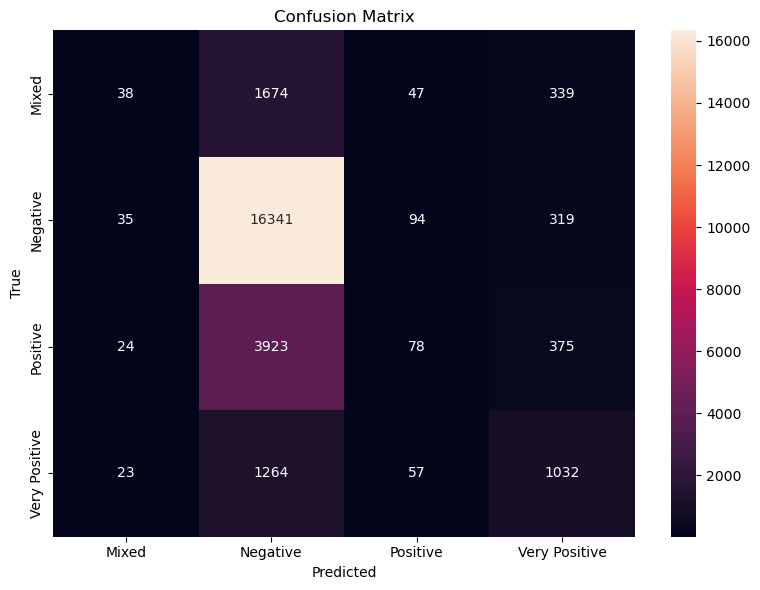

In [94]:
# Get predictions
y_pred_train_enc = clf_pipeline.predict(X_train[feature_columns])
y_pred_test_enc  = clf_pipeline.predict(X_test[feature_columns])

# # Get accuracy on predictions.
#Look at both train and test split to see if model is overfitting (i.e, large differences in results between train and test)
print("Train accuracy:", accuracy_score(y_train_enc, y_pred_train_enc))
print("Test accuracy:",  accuracy_score(y_test_enc,  y_pred_test_enc))

# Decode back to string labels - So plot shows 'Negative', 'Positive' instead of 1,2 etc.
y_pred_train = le.inverse_transform(y_pred_train_enc)
y_pred_test = le.inverse_transform(y_pred_test_enc)

# Classification report
print("\nClassification Report (test):\n", classification_report(y_test, y_pred_test, digits=3))

# CM
cm = confusion_matrix(y_test_enc, y_pred_test_enc)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=le.classes_,
            yticklabels=le.classes_)
plt.ylabel("True")
plt.xlabel("Predicted")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()